### Notatki
- trzeba zamienić x i y (kolumny) miejscami,
- wynikowy obraz jest obrócony (przez odejmowanie?) i przerzucony w poziomie,
- dobrze jest przyciąć wg maski, żeby ograniczyć rozmiar,

In [56]:
import cv2
import numpy as np
from pyproj import Proj, transform
import json
import os
import matplotlib.pyplot as plt
from PIL import Image

In [57]:
def convert_coords(x, y, proj_src="EPSG:2180", proj_dst="EPSG:4326"):
    proj_src = Proj(proj_src)
    proj_dst = Proj(proj_dst)

    lon, lat = transform(proj_src, proj_dst, x, y)

    return lon, lat

In [58]:
path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images"
data_weti1 = {}
data_weti2 = {}
for i, filename in enumerate(os.listdir(path)):
        f = os.path.join(path, filename)
        if os.path.isfile(f) and filename.endswith(".json"):
                with open(f) as json_file:
                        json_data = json.load(json_file)
                for obj in json_data['objects']:
                        id_data, point_data = obj['tags'].split(';')
                        _, name = id_data.split()
                        x, y = point_data.replace(point_data.split()[0], '').split(',')
                        if 'weti1' in filename:
                                data_weti1[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }
                        elif 'weti2' in filename:
                                data_weti2[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }


### Load and preprocess images

In [59]:
def crop_img_with_mask(image, mask):
    alpha_channel = mask[:, :, 3]

    rows, cols = alpha_channel.shape
    first_row, last_row = 0, rows - 1
    first_col, last_col = 0, cols - 1

    for i in range(rows):
        if np.any(alpha_channel[i, :] == 0):
            first_row = i
            break

    for i in range(rows - 1, -1, -1):
        if np.any(alpha_channel[i, :] == 0):
            last_row = i
            break

    for j in range(cols):
        if np.any(alpha_channel[:, j] == 0):
            first_col = j
            break

    for j in range(cols - 1, -1, -1):
        if np.any(alpha_channel[:, j] == 0):
            last_col = j
            break

    cropped_image = image[first_row:last_row+1, first_col:last_col+1]
    return cropped_image, (first_col, first_row, last_col, last_row)

(380, 335, 799, 1079)
(225, 121, 1760, 1079)


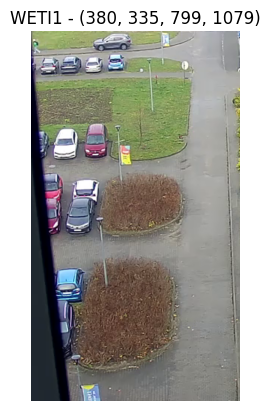

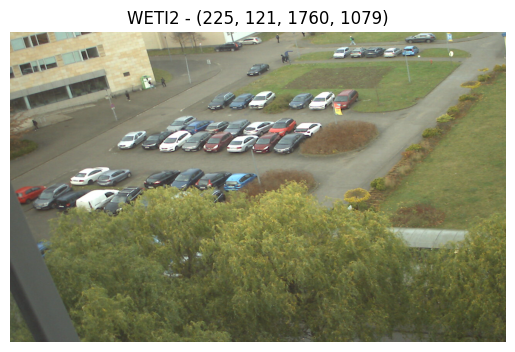

In [60]:
image_weti1 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf1.jpg"), cv2.COLOR_RGB2BGR)
image_weti2 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf2.jpg"), cv2.COLOR_RGB2BGR)

mask_weti1 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti1_mask.jpg").convert("RGBA"))
mask_weti2 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti2_mask.jpg").convert("RGBA"))

image_c_weti1, bbox_weti1 = crop_img_with_mask(image_weti1, mask_weti1)
image_c_weti2, bbox_weti2 = crop_img_with_mask(image_weti2, mask_weti2)
print(bbox_weti1)
print(bbox_weti2)

plt.imshow(image_c_weti1)
plt.title(f"WETI1 - {bbox_weti1}")
plt.axis("off")
plt.show()
plt.imshow(image_c_weti2)
plt.title(f"WETI2 - {bbox_weti2}")
plt.axis("off")
plt.show()

In [61]:
keys_weti1 = data_weti1.keys()
geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in keys_weti1])

keys_weti2 = data_weti2.keys()
geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
img_points_weti2 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in keys_weti2])

# print(geo_points_weti1[:, 0].min(), geo_points_weti2[:, 0].min(), min(geo_points_weti1[:, 0].min(), geo_points_weti2[:, 0].min()))
minx = min(geo_points_weti1[:, 0].min(), geo_points_weti2[:, 0].min())
miny = min(geo_points_weti1[:, 1].min(), geo_points_weti2[:, 1].min())

geo_points_weti1[:, 0] -= minx
geo_points_weti1[:, 1] -= miny
geo_points_weti2[:, 0] -= minx
geo_points_weti2[:, 1] -= miny

In [49]:
# keys_weti1 = data_weti1.keys()
# geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
# img_points_weti1 = np.array([data_weti1[k]['img_coords'] for k in keys_weti1])
# # print(img_points_weti1, '\n--------')
# keys_weti2 = data_weti2.keys()
# geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
# img_points_weti2 = np.array([data_weti2[k]['img_coords'] for k in keys_weti2])
# # print(img_points_weti2, '\n------------------------------------')

keys_weti1 = data_weti1.keys()
geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in keys_weti1])
# print(img_points_weti1, '\n--------')
keys_weti2 = data_weti2.keys()
geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
img_points_weti2 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in keys_weti2])
# print(img_points_weti2)

In [50]:
# print(img_points_weti1,'\n----------------------------------')

# print(geo_points_weti1,'\n----------------------------------')

# Offset EPSG:2180 points to start at (0, 0) by subtracting minimums
geo_points_weti1[:, 0] -= geo_points_weti1[:, 0].min()
geo_points_weti1[:, 1] -= geo_points_weti1[:, 1].min()

# print(geo_points_weti1,'\n----------------------------------')

# tmp = geo_points_weti1[:, 0]
# geo_points_weti1[:, 0] = geo_points_weti1[:, 1]
# geo_points_weti1[:, 1] = tmp

# Scale geo points to match image dimensions for homography calculation
scale_x = image_weti1.shape[1] / geo_points_weti1[:, 0].max()
scale_y = image_weti1.shape[0] / geo_points_weti1[:, 1].max()

geo_points_weti1[:, 0] *= scale_x
geo_points_weti1[:, 1] *= scale_y

# print(geo_points_weti1)

# # Compute the homography matrix
# homography_matrix_weti1, status_weti1 = cv2.findHomography(img_points_weti1, geo_points_weti1)

# # Warp the image using the computed homography
# img1_warp = cv2.warpPerspective(image_weti1, homography_matrix_weti1, (image_weti1.shape[1], image_weti1.shape[0]))

# # Display the transformed image
# plt.imshow(img1_warp)
# plt.show()


# Homography

In [97]:
def make_image_top_down(image, geo_points_og, img_points_og, aa=False, figsize=None, draw_points=None):
    geo_points = geo_points_og.copy()
    img_points = img_points_og.copy()

    if aa:
        scale_x = image.shape[1] / geo_points[:, 0].max()
        scale_y = image.shape[0] / geo_points[:, 1].max()

        geo_points[:, 0] *= max(scale_x, scale_y)
        geo_points[:, 1] *= max(scale_x, scale_y)

    homography_matrix, _ = cv2.findHomography(img_points, geo_points)

    height, width = image.shape[:2]

    image_corners = np.array([
        [0, 0],              
        [width, 0],          
        [width, height],     
        [0, height]          
    ], dtype="float32")

    transformed_corners = cv2.perspectiveTransform(image_corners.reshape(-1, 1, 2), homography_matrix).reshape(-1, 2)

    x_min, y_min = transformed_corners.min(axis=0)
    x_max, y_max = transformed_corners.max(axis=0)

    output_width = int(x_max - x_min)
    output_height = int(y_max - y_min)

    translation_matrix = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])

    adjusted_homography = np.dot(translation_matrix, homography_matrix)

    img1_warp_full = cv2.warpPerspective(image, adjusted_homography, (output_width, output_height))

    if figsize is not None:
        print(f"{figsize=}")
        plt.figure(figsize=figsize)
    plt.imshow(cv2.flip(cv2.rotate(img1_warp_full, cv2.ROTATE_180), 1))
    plt.show()

    return adjusted_homography

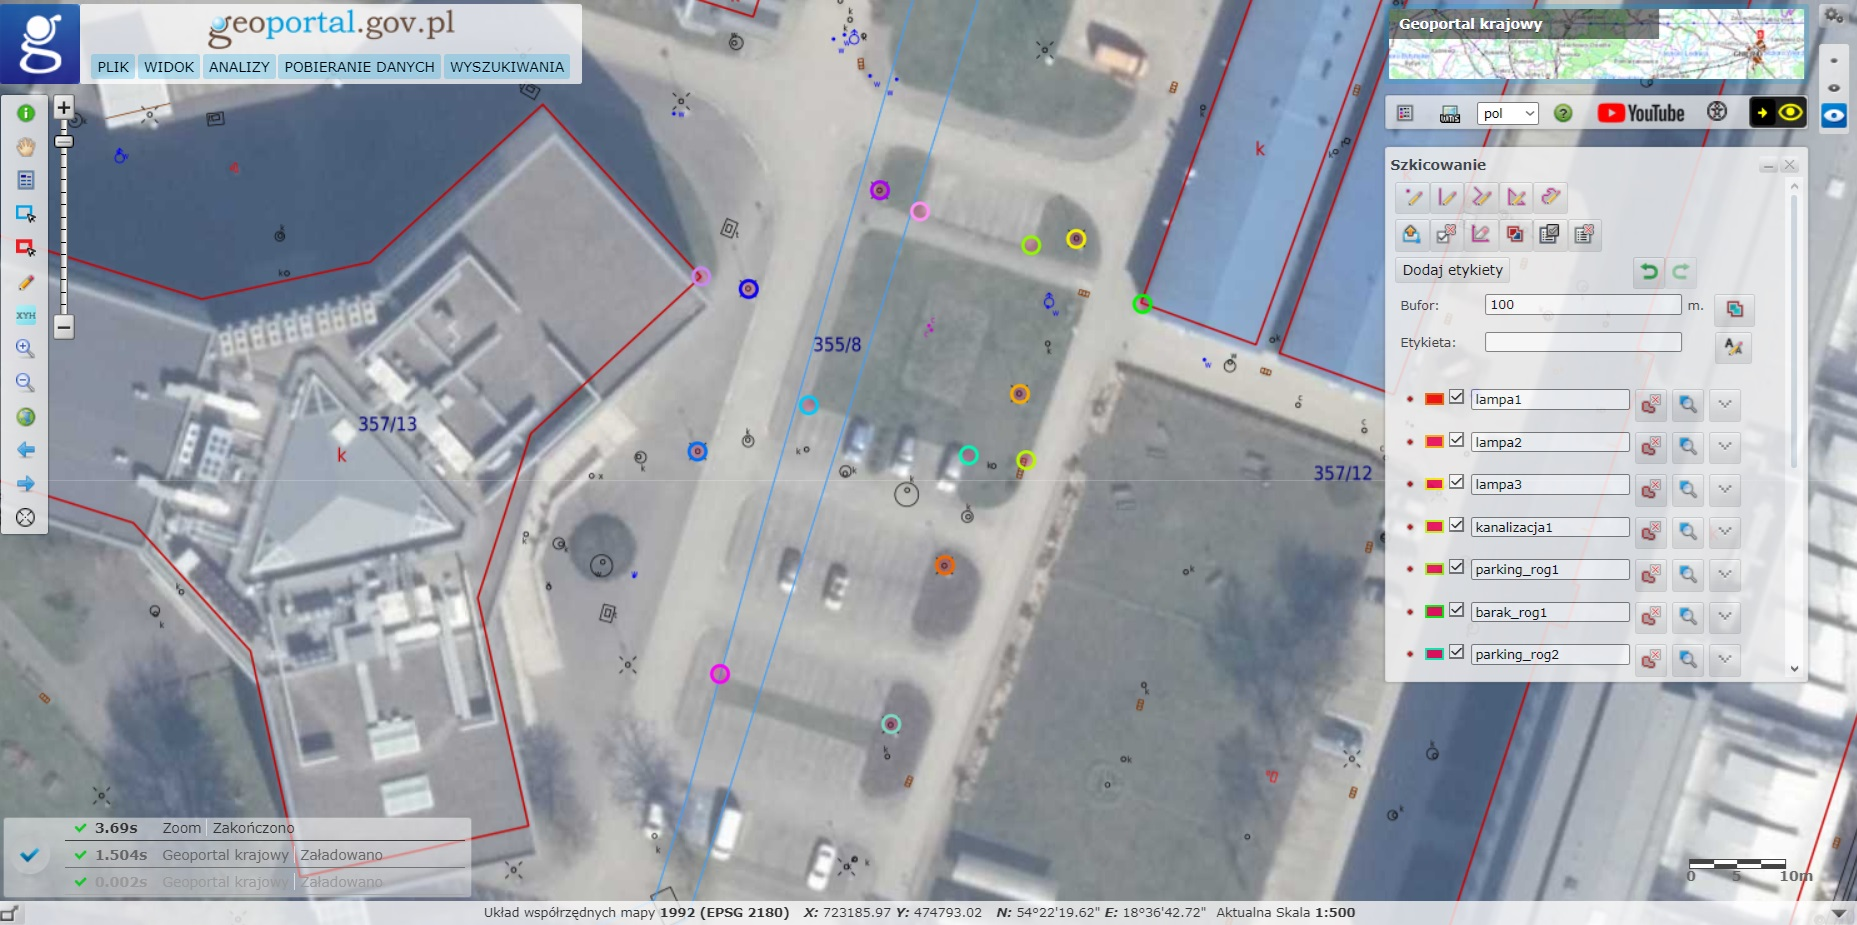

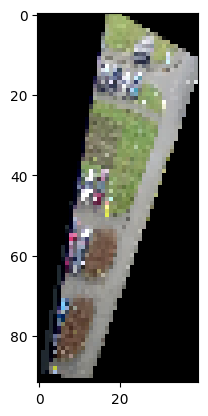

In [98]:
homography_weti1 = make_image_top_down(image_c_weti1, geo_points_weti1, img_points_weti1)

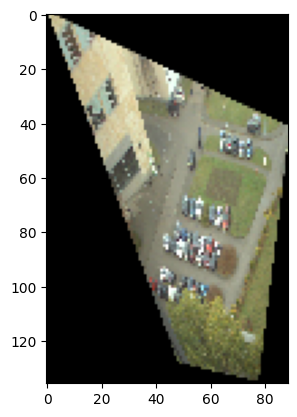

In [99]:
homography_weti2 = make_image_top_down(image_c_weti2, geo_points_weti2, img_points_weti2)

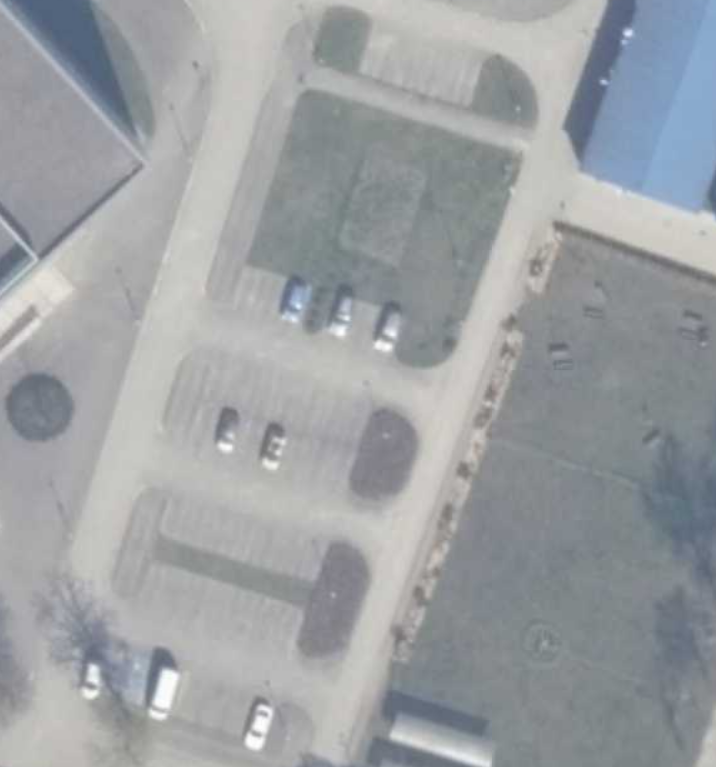

### Testy punktów

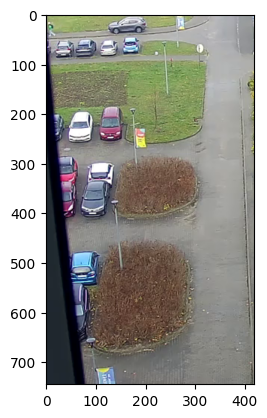

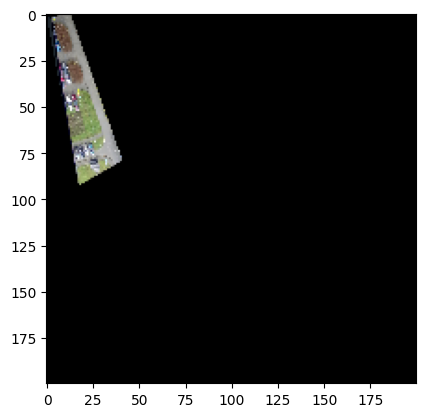

In [100]:
image_c_weti1_h = cv2.warpPerspective(image_c_weti1, homography_weti1, (200, 200))
plt.imshow(image_c_weti1)
plt.show()
plt.imshow(image_c_weti1_h)
plt.show()

In [109]:
print(data_weti1['kanalizacja1'])

lampa1 = [530.64, 846.46]
lampa2 = [560.09, 637.50]
p1 = np.dot(homography_weti1, np.array([*lampa1, 1])) 
p1 /= p1[2]  # Normalize to get (x, y)
print("Transformed lampa1 in Image:", p1[:2])
p2 = np.dot(homography_weti1, np.array([*lampa2, 1])) 
p2 /= p2[2]  # Normalize to get (x, y)
print("Transformed lampa2 in Image:", p2[:2])

{'geo_coords': [474901.7284840405, 723137.3163787997], 'img_coords': [[685.6296518098134, 546.0572355241823]]}
Transformed lampa1 in Image: [14.0855802  -5.43520527]
Transformed lampa2 in Image: [19.33831816  5.49533688]


In [112]:
((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

12.12715992509934

In [106]:
common_keys = list(set(data_weti1.keys()).intersection(data_weti2.keys()))
dx1, dy1, _, _ = bbox_weti1
dx2, dy2, _, _ = bbox_weti2

for ck in common_keys:
    x1, y1 = data_weti1[ck]['img_coords'][0]
    x2, y2 = data_weti2[ck]['img_coords'][0]
    print(ck, [x1-dx1, y1-dy1], [x2-dx2, y2-dy2])


for g, i in zip(geo_points_weti1, img_points_weti1):
    print(f"{g}     | {i}   | {np.dot(homography_weti1, np.array([*i[0], 1]))}")

lampa3 [264.4049647534041, 65.46368951090886] [1357.6062722985157, 62.62819724964828]
lampa2 [243.82087858502712, 160.3220315885585] [1237.9889874915066, 153.39526404195192]
kanalizacja1 [305.62965180981337, 211.05723552418226] [1270.8291724679848, 204.95548090185298]
parking_rog2 [162.1019071708822, 222.9471525326719] [1088.9459162195803, 211.49951520613968]
barak_rog1 [422.80198167115657, 82.08924653520671] [1537.3800289089718, 81.79872178294895]
parking_rog1 [189.88585458347018, 79.7289625379866] [1255.0660280280613, 73.46299862072735]
lampa1 [180.68476131769705, 307.5630612828934] [1012.2856199994599, 299.5298865172681]
[26.12765642 16.83414825]     | [[180.68476132 307.56306128]]   | [22.4649351  54.33910975  1.50836867]
[34.0651723 35.0242888]     | [[243.82087859 160.32203159]]   | [30.18507118 71.35335004  1.30920002]
[40.08445517 51.42848827]     | [[264.40496475  65.46368951]]   | [33.78518549 82.49302716  1.1749528 ]
[34.72663195 28.01281644]     | [[305.62965181 211.0572355

### HD

figsize=(8, 8)


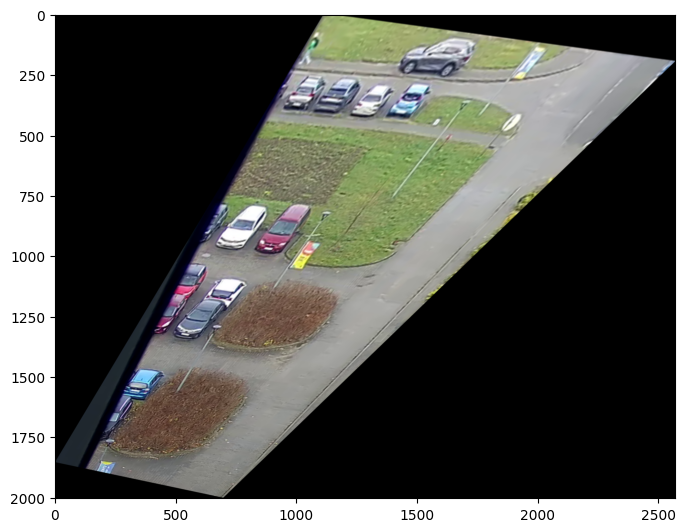

In [54]:
_ = make_image_top_down(image_c_weti1, geo_points_weti1, img_points_weti1, aa=True, figsize=(8, 8))

figsize=(8, 8)


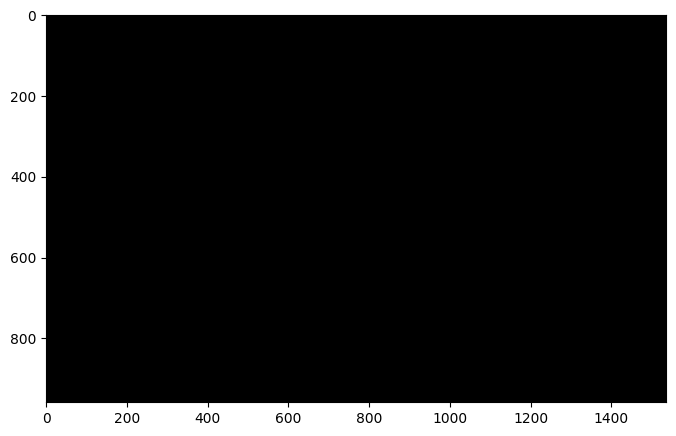

In [55]:
_ = make_image_top_down(image_c_weti2, geo_points_weti2, img_points_weti2, aa=True, figsize=(8, 8))

In [175]:
scaling_factor = np.sqrt(np.abs(np.linalg.det(homography_weti1[:2, :2])))
print(f"Approximate Scaling Factor: {scaling_factor:.4f} meters/pixel")

Approximate Scaling Factor: 0.1032 meters/pixel


In [176]:
geo_test = [[34.0651723 , 35.0242888], [40.08445517, 51.42848827]]

img_test = [[243.82087859, 160.32203159, 1], [264.40496475,  65.46368951, 1]]

p1_h = np.dot(homography_weti1, img_test[0])
p2_h = np.dot(homography_weti1, img_test[1])
print(p1_h, p2_h)

[44.98762791 46.73781118  1.30920002] [47.06986721 60.40160032  1.1749528 ]


In [139]:
p1 = [210, 568, 1]
p2 = [260, 347, 1]

p1_h = np.dot(homography_weti1, p1)
p2_h = np.dot(homography_weti1, p2)
print(p1_h, p2_h)

[180.12496455 322.62392548   1.97344328] [259.85914127 723.27424498   1.65774688]


In [121]:
homography_matrix = homography_weti1

# Example points to measure distance
point1_geo = np.array([723132.4546503258, 474911.31964905583])
point2_geo = np.array([723142.4546503258, 474921.31964905583])

# Convert geo-coordinates to homogeneous form
point1_homogeneous = np.append(point1_geo, 1)
point2_homogeneous = np.append(point2_geo, 1)
print(f"{point1_homogeneous=}, {point2_homogeneous=}")

# Map geo-coordinates back to image pixel coordinates
point1_img = np.dot(np.linalg.inv(homography_matrix), point1_homogeneous)
point1_img /= point1_img[2]  # Normalize to get [x, y, 1]

point2_img = np.dot(np.linalg.inv(homography_matrix), point2_homogeneous)
point2_img /= point2_img[2]  # Normalize to get [x, y, 1]

# Calculate distance in the geo-coordinate space (meters)
distance_geo = np.linalg.norm(point1_geo - point2_geo)
print(f"Distance in real-world coordinates: {distance_geo:.2f} meters")

# Calculate distance in the pixel space
distance_img = np.linalg.norm(point1_img[:2] - point2_img[:2])
print(f"Distance in image pixel coordinates: {distance_img:.2f} pixels")

# Scaling factor: meters per pixel
scaling_factor = distance_geo / distance_img
print(f"Scaling factor: {scaling_factor:.4f} meters/pixel")

point1_homogeneous=array([7.23132455e+05, 4.74911320e+05, 1.00000000e+00]), point2_homogeneous=array([7.23142455e+05, 4.74921320e+05, 1.00000000e+00])
Distance in real-world coordinates: 14.14 meters
Distance in image pixel coordinates: 1.28 pixels
Scaling factor: 11.0620 meters/pixel


## Wersja 2 - bez zbędnych przekształceń

In [ ]:
def find_homography(img_points, geo_points, img_diff=None):


In [167]:
# load points
path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images"
data_weti1 = {}
data_weti2 = {}
for i, filename in enumerate(os.listdir(path)):
        f = os.path.join(path, filename)
        if os.path.isfile(f) and filename.endswith(".json"):
                with open(f) as json_file:
                        json_data = json.load(json_file)
                for obj in json_data['objects']:
                        id_data, point_data = obj['tags'].split(';')
                        _, name = id_data.split()
                        x, y = point_data.replace(point_data.split()[0], '').split(',')
                        if 'weti1' in filename:
                                data_weti1[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }
                        elif 'weti2' in filename:
                                data_weti2[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }


(380, 335, 799, 1079)
(225, 121, 1760, 1079)


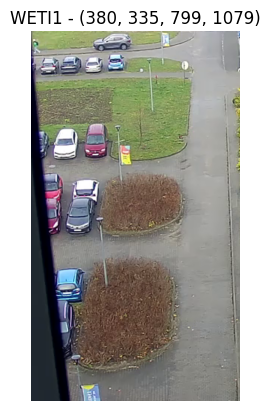

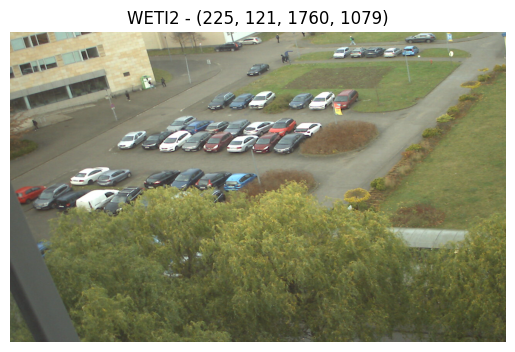

In [168]:
# load and preprocess images
image_weti1 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf1.jpg"), cv2.COLOR_RGB2BGR)
image_weti2 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf2.jpg"), cv2.COLOR_RGB2BGR)

mask_weti1 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti1_mask.jpg").convert("RGBA"))
mask_weti2 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti2_mask.jpg").convert("RGBA"))

image_c_weti1, bbox_weti1 = crop_img_with_mask(image_weti1, mask_weti1)
image_c_weti2, bbox_weti2 = crop_img_with_mask(image_weti2, mask_weti2)
print(bbox_weti1)
print(bbox_weti2)

plt.imshow(image_c_weti1)
plt.title(f"WETI1 - {bbox_weti1}")
plt.axis("off")
plt.show()
plt.imshow(image_c_weti2)
plt.title(f"WETI2 - {bbox_weti2}")
plt.axis("off")
plt.show()

In [174]:
keys_weti1 = data_weti1.keys()
geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in keys_weti1])

keys_weti2 = data_weti2.keys()
geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
img_points_weti2 = np.array([data_weti2[k]['img_coords'] for k in keys_weti2])
img_points_weti2 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in keys_weti2])

minx = min(geo_points_weti1[:, 0].min(), geo_points_weti2[:, 0].min())
miny = min(geo_points_weti1[:, 1].min(), geo_points_weti2[:, 1].min())

geo_points_weti1[:, 0] -= minx
geo_points_weti1[:, 1] -= miny
geo_points_weti2[:, 0] -= minx
geo_points_weti2[:, 1] -= miny

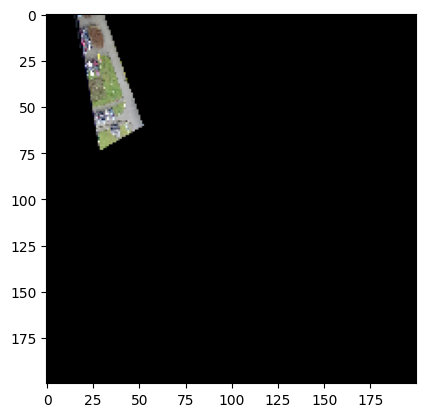

In [175]:
H, status = cv2.findHomography(img_points_weti1, geo_points_weti1)
warped_image = cv2.warpPerspective(image_c_weti1, H, (200, 200))
plt.imshow(warped_image)
plt.show()

In [176]:
H1, status1 = cv2.findHomography(img_points_weti1, geo_points_weti1)
H2, status2 = cv2.findHomography(img_points_weti2, geo_points_weti2)

In [211]:
common_keys = list(set(data_weti1.keys()).intersection(data_weti2.keys()))
cgeo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in common_keys])
cimg_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in common_keys])

keys_weti2 = data_weti2.keys()
cgeo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in common_keys])
cimg_points_weti2 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in common_keys])

dx1, dy1, _, _ = bbox_weti1
dx2, dy2, _, _ = bbox_weti2

point_test1 = [562.262 - bbox_weti1[0], 641.650 - bbox_weti1[1], 1]
print('lampa1', point_test1, data_weti1['lampa1']['img_coords'])
print(f"lampa1 transform", np.dot(H1, point_test1))

print(minx, miny)
for ck, cimg1, cimg2 in zip(common_keys, cimg_points_weti1, cimg_points_weti2):
    print(ck, cimg1, cimg2)

print()

for ck in common_keys:
    img_point_weti1 = data_weti1[ck]['img_coords'][0]
    img_point_weti2 = data_weti2[ck]['img_coords'][0]
    geo_point = [data_weti1[ck]['geo_coords'][0] - minx, data_weti1[ck]['geo_coords'][1] - miny]
    print(f"{ck:<15} weti1 {np.dot(H1, np.array([*img_point_weti1, 1]))} weti2 {np.dot(H2, np.array([*img_point_weti2, 1]))} geo {geo_point}")
    print(f"{ck:<15} {str(data_weti1[ck]['img_coords'][0]):<50} {str(data_weti1[ck]['geo_coords']):<50} {str(data_weti2[ck]['img_coords'][0]):<50} {str(data_weti2[ck]['geo_coords']):<40}")


for g, i in zip(geo_points_weti1, img_points_weti1):
    print(f"{g}     | {i}   | {np.dot(homography_weti1, np.array([*i[0], 1]))}")

lampa1 [182.26199999999994, 306.65, 1] [[560.684761317697, 642.5630612828934]]
lampa1 transform [39.63833691 26.09041957  1.50748388]
474867.00185208715 723109.3035623572
lampa3 [[264.40496475  65.46368951]] [[1357.6062723    62.62819725]]
lampa2 [[243.82087859 160.32203159]] [[1237.98898749  153.39526404]]
kanalizacja1 [[305.62965181 211.05723552]] [[1270.82917247  204.9554809 ]]
parking_rog2 [[162.10190717 222.94715253]] [[1088.94591622  211.49951521]]
barak_rog1 [[422.80198167  82.08924654]] [[1537.38002891   81.79872178]]
parking_rog1 [[189.88585458  79.72896254]] [[1255.06602803   73.46299862]]
lampa1 [[180.68476132 307.56306128]] [[1012.28562     299.52988652]]

lampa3          weti1 [72.17675295  5.61145684  1.78279109] weti2 [76.40849887 42.02484397  1.63385802] geo [40.08445516898064, 51.42848827387206]
lampa3          [644.4049647534041, 400.46368951090886]            [474907.08630725613, 723160.7320506311]            [1582.6062722985157, 183.62819724964828]           [474907

# Działająca transformacja :O

In [228]:
print("weti1")
for k, img, geo in zip(keys_weti1, img_points_weti1, geo_points_weti1):
    transformed_point = np.dot(H1, np.array([*img[0], 1]))
    transformed_point /= transformed_point[2]
    print(k, img[0], geo, transformed_point)

print("weti2")
for k, img, geo in zip(keys_weti2, img_points_weti2, geo_points_weti2):
    transformed_point = np.dot(H2, np.array([*img[0], 1]))
    transformed_point /= transformed_point[2]
    print(k, img[0], geo, transformed_point)

weti1
lampa1 [180.68476132 307.56306128] [26.12765642 16.83414825] [26.20009695 17.22311563  1.        ]
lampa2 [243.82087859 160.32203159] [34.0651723 35.0242888] [34.36268505 35.69951919  1.        ]
lampa3 [264.40496475  65.46368951] [40.08445517 51.42848827] [40.06107055 51.40768214  1.        ]
kanalizacja1 [305.62965181 211.05723552] [34.72663195 28.01281644] [35.00526091 27.36404273  1.        ]
barak_rog1 [422.80198167  82.08924654] [47.02978156 44.54930785] [46.79416894 44.66514722  1.        ]
parking_rog1 [189.88585458  79.72896254] [35.32194564 50.70088265] [35.46321248 50.57560796  1.        ]
parking_rog2 [162.10190717 222.94715253] [28.64120312 28.4758382 ] [28.1103515 28.0906586  1.       ]
weti2
lampa1 [1012.28562     299.52988652] [26.12765642 16.83414825] [26.12352546 17.15337661  1.        ]
lampa2 [1237.98898749  153.39526404] [34.0651723 35.0242888] [34.15619354 35.62241289  1.        ]
lampa3 [1357.6062723    62.62819725] [40.08445517 51.42848827] [39.97443347 51

In [226]:
point = np.array([180.68476132, 307.56306128, 1])  # Convert to homogeneous coordinates
transformed_point = np.dot(H, point)  # Apply homography
x_transformed = transformed_point[0] / transformed_point[2]  # Normalize by w
y_transformed = transformed_point[1] / transformed_point[2]  # Normalize by w

# Final transformed point
transformed_point_cartesian = (x_transformed, y_transformed)
print(transformed_point_cartesian)

(26.200096949030083, 17.22311562889055)


In [131]:
image_point = np.array([180.68476132, 307.56306128, 1])

transformed_point = np.dot(H, image_point)

real_world_point = transformed_point[:2] / transformed_point[2]
print(real_world_point)

[16.00443491 89.69051342]


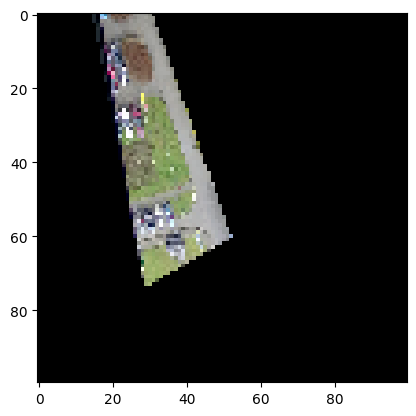

In [200]:
output_size = (100, 100)

warped_image1 = cv2.warpPerspective(image_c_weti1, H1, output_size)
cv2.imwrite(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\warped1.jpg", warped_image1)
plt.imshow(warped_image)
plt.show()

In [203]:
point_test1 = [702.007 - bbox_weti1[0], 426.884 - bbox_weti1[1], 1]
print(point_test1)
np.dot(H1, point_test1)

[322.00699999999995, 91.88400000000001, 1]


array([51.03136867, 55.6815663 ,  1.2310541 ])

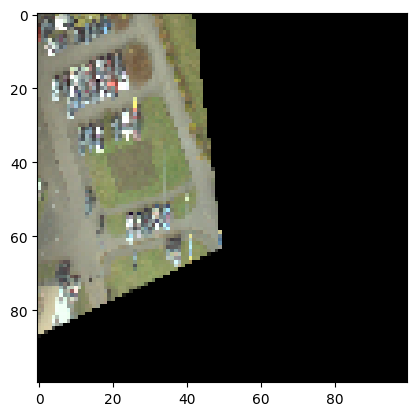

In [201]:
output_size = (100, 100)

warped_image2 = cv2.warpPerspective(image_c_weti2, H2, output_size)
cv2.imwrite(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\warped2.jpg", warped_image2)
plt.imshow(warped_image2)
plt.show()

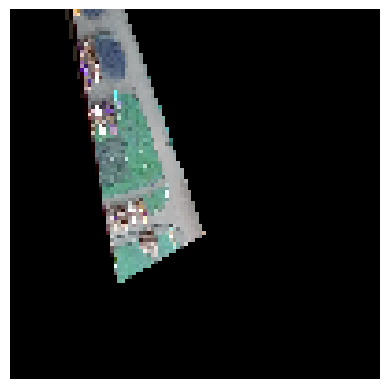

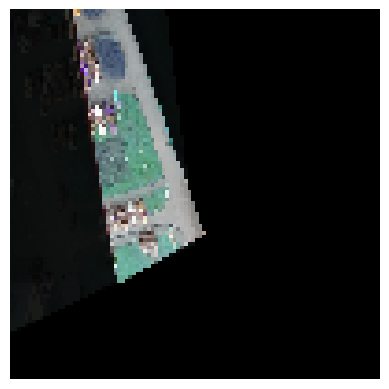

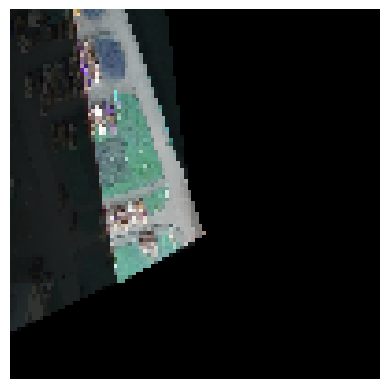

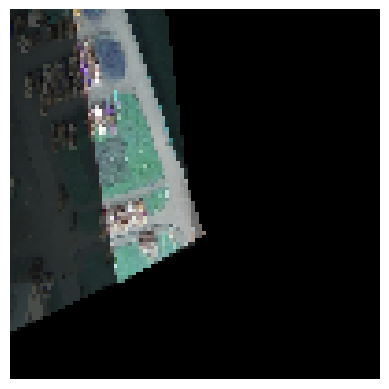

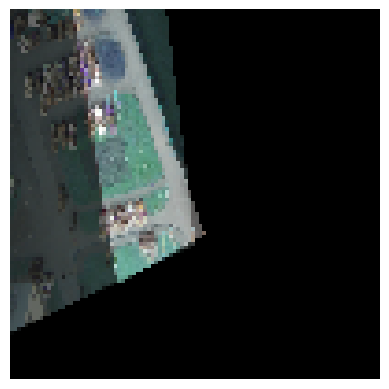

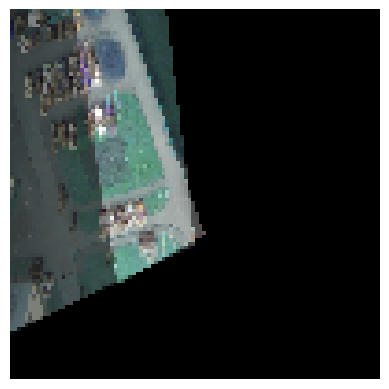

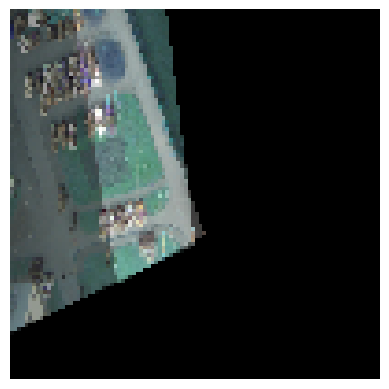

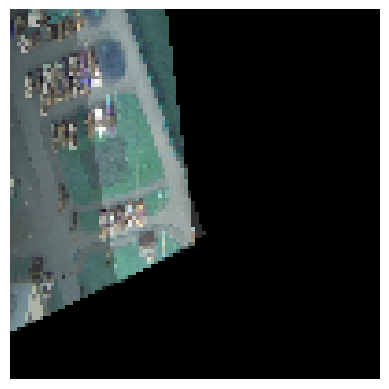

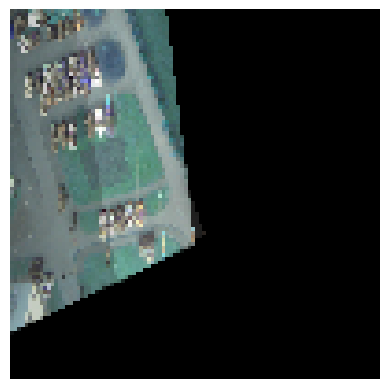

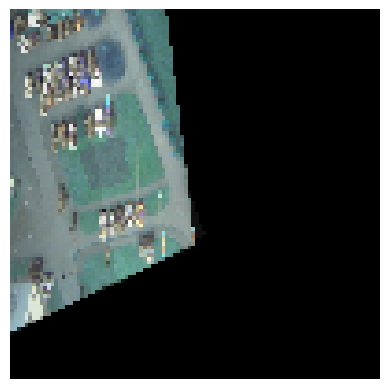

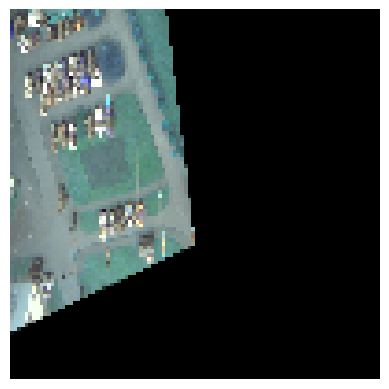

In [198]:
frames = []
num_steps = 10
for i in range(num_steps + 1):
    alpha = i / num_steps
    blended = cv2.addWeighted(warped_image1, 1 - alpha, warped_image2, alpha, 0)
    frames.append(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))

# Display the frames as a loop
for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    plt.pause(0.05)
plt.show()

In [195]:
n = 100
for i in range(n):
    merged_image = cv2.addWeighted(warped_image1, 1-i/n, warped_image2, i/n, 0)
    cv2.imwrite(fr"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\merging\merging_{i}.jpg", merged_image)
    # plt.imshow(merged_image)
    # plt.show()

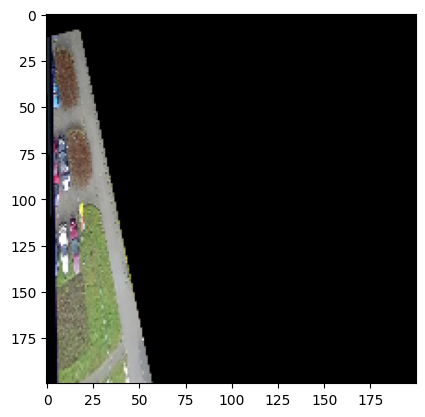

In [171]:
H_load = np.load('homography_weti1.npy')
output_size = (200, 200)

warped_image = cv2.warpPerspective(image_c_weti1, H_load, output_size)
plt.imshow(warped_image)
plt.show()